## **Face Recognition**

**Facial Recognition System** is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image. 

We'll be building a face recognition model that uses **Siamese Networks** to give us a distance value that indicates whether 2 images are same or different. 

#### **The Dataset**
We'll be using the **Extracted Faces** from **face-recognition-dataset**, which is derived from the **LFW Dataset**.
The Extracted Faces contains faces extracted from the base images using **Haar-Cascade Face-Detection** (CV2).
- The dataset contains 1324 different individuals, with 2-50 images per person.
- The images are of size (128,128,3) and are encoded in RGB.
- Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import os 
# os.listdir('/content/drive/MyDrive/capstone_project/selected/RGBFace/train')

# rename_dict = {}
# for i,name in enumerate(os.listdir('/content/drive/MyDrive/capstone_project/selected/RGBFace/train'),1):
#   rename_dict[name] = "class_" +str(i)



In [3]:
# import os

# folder_path = '/content/drive/MyDrive/capstone_project/selected/RGBFace/test'

# for subdir, dirs, files in os.walk(folder_path):
#     for old_name in dirs:
#         if old_name in rename_dict:
#             new_name = rename_dict[old_name]
#             old_path = os.path.join(subdir, old_name)
#             new_path = os.path.join(subdir, new_name)
#             os.rename(old_path, new_path)

In [4]:
# import os

# folder_path = '/content/drive/MyDrive/capstone_project/selected/RGBFace/train'

# for subdir, dirs, files in os.walk(folder_path):
#     for old_name in dirs:
#         if old_name in rename_dict:
#             new_name = rename_dict[old_name]
#             old_path = os.path.join(subdir, old_name)
#             new_path = os.path.join(subdir, new_name)
#             os.rename(old_path, new_path)

## **Reading the Dataset**

We're reading the folders and splitting them into **train and test set** for training purposes.

In [5]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.11.0', '1.22.4')

In [6]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT_train = "/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new"
ROOT_test = "/content/drive/MyDrive/capstone_project/selected/RGBFace/test_new"

def read_image(index, ROOT):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [7]:
# def split_dataset(directory, split=0.75):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)
    
#     random.shuffle(folders)
    
#     train_list, test_list = {}, {}
    
#     # Creating Train-list
#     for folder in folders[:num_train]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files
    
#     # Creating Test-list
#     for folder in folders[num_train:]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files  
    
#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=1)
# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTest List:", test_list)

In [8]:
# import os
# import shutil

# def keep_n_images(train_dir_path, n,name ='train_new'):
#     # Create a new directory called train_new
#     new_train_dir_path = os.path.join(os.path.dirname(train_dir_path), name)
#     if not os.path.exists(new_train_dir_path):
#         os.makedirs(new_train_dir_path)

#     # Iterate over nested directories
#     for root, dirs, files in os.walk(train_dir_path):
#         # Create a corresponding subdirectory in the new directory
#         new_subdir_path = os.path.join(new_train_dir_path, os.path.relpath(root, train_dir_path))
#         if not os.path.exists(new_subdir_path):
#             os.makedirs(new_subdir_path)

#         # Copy only n images to the new subdirectory
#         num_images = len(files)
#         if num_images > n:
#             files_to_copy = files[:n]
#         else:
#             files_to_copy = files
#         for file_name in files_to_copy:
#             old_file_path = os.path.join(root, file_name)
#             new_file_path = os.path.join(new_subdir_path, file_name)
#             shutil.copy2(old_file_path, new_file_path)

# keep_n_images('/content/drive/MyDrive/capstone_project/selected/RGBFace/test',11,"test_new")

# keep_n_images('/content/drive/MyDrive/capstone_project/selected/RGBFace/train',41)

In [9]:

# def rename_images(path):
#     # Loop over each directory
#     for subdir, dirs, files in os.walk(path):
#         # Loop over each file in the directory
#         for i, file in enumerate(sorted(files)):
#             # Split the file name and extension
#             file_name, file_ext = os.path.splitext(file)
#             # Rename the file
#             new_name = f"{i+1}{file_ext}"
#             os.rename(os.path.join(subdir, file), os.path.join(subdir, new_name))

# rename_images('/content/drive/MyDrive/capstone_project/selected/RGBFace/test_new')
# rename_images('/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new')

Renaming images

In [10]:
import os
from collections import defaultdict

# Set the path to your training directory
training_dir = "/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new"

# Create a defaultdict to store the counts of images for each directory
image_counts = defaultdict(int)

# Walk through the training directory and its subdirectories
for root, dirs, files in os.walk(training_dir):
    # Iterate over the files in each directory and increment the count for that directory
    for file in files:
        directory = os.path.basename(root)
        image_counts[directory] += 1

# Convert the defaultdict to a regular dictionary for easier use
train_list = dict(image_counts)
train_list

{'class_10': 41,
 'class_5': 41,
 'class_2': 41,
 'class_11': 41,
 'class_3': 41,
 'class_1': 41,
 'class_12': 41,
 'class_4': 41,
 'class_8': 41,
 'class_6': 41,
 'class_9': 41,
 'class_7': 41}

In [11]:
import os
from collections import defaultdict

# Set the path to your training directory
training_dir = "/content/drive/MyDrive/capstone_project/selected/RGBFace/test_new"

# Create a defaultdict to store the counts of images for each directory
image_counts = defaultdict(int)

# Walk through the training directory and its subdirectories
for root, dirs, files in os.walk(training_dir):
    # Iterate over the files in each directory and increment the count for that directory
    for file in files:
        directory = os.path.basename(root)
        image_counts[directory] += 1

# Convert the defaultdict to a regular dictionary for easier use
test_list = dict(image_counts)
test_list

{'class_7': 11,
 'class_4': 11,
 'class_5': 11,
 'class_1': 11,
 'class_6': 11,
 'class_2': 11,
 'class_3': 11,
 'class_12': 11,
 'class_10': 11,
 'class_11': 11,
 'class_8': 11,
 'class_9': 11}

### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [12]:
def create_triplets(directory, folder_list, max_files=40):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(1,num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(1, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [13]:
train_triplet = create_triplets(ROOT_train, train_list)
test_triplet  = create_triplets(ROOT_test, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(test_triplet[i])

Number of training triplets: 8892
Number of testing triplets : 540

Examples of triplets:
(('class_7', '5.jpg'), ('class_7', '8.jpg'), ('class_4', '6.jpg'))
(('class_1', '3.jpg'), ('class_1', '7.jpg'), ('class_10', '8.jpg'))
(('class_8', '1.jpg'), ('class_8', '4.jpg'), ('class_5', '6.jpg'))
(('class_4', '6.jpg'), ('class_4', '8.jpg'), ('class_9', '8.jpg'))
(('class_4', '3.jpg'), ('class_4', '6.jpg'), ('class_3', '7.jpg'))


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [14]:
def get_batch(triplet_list,ROOT, batch_size=16, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a,ROOT))
            positive.append(read_image(p,ROOT))
            negative.append(read_image(n,ROOT))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

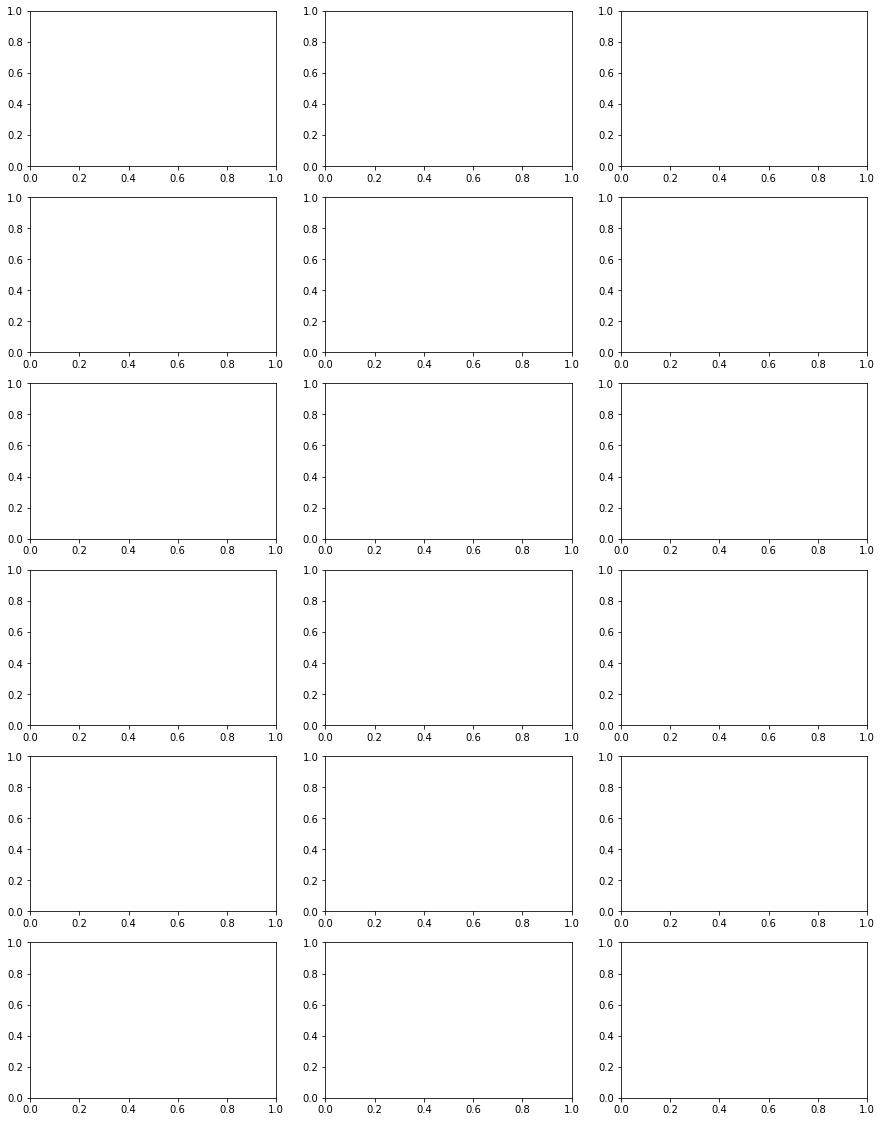

In [15]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False,ROOT=ROOT_train):
    a,p,n = x
    break
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## **Creating the Model**

Unlike a conventional CNN, the **Siamese Network** does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

![Siamese Network Image](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [16]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

The **Encoder** is responsible for converting the passed images into their feature vectors. We're using a pretrained model, **Xception model** which is based on **Inception_V3 model.** By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to **Fully Connected (Dense)** layers and the last layer normalises the data using **L2 Normalisation**. *(L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)*

In [17]:
# def get_encoder(input_shape):
#     """ Returns the image encoding model """

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )
    
#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model





from tensorflow.keras import regularizers

def get_encoder(input_shape, l2_reg=0.01, dropout_rate=0.2):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    
    return encode_model


# 56 accuracy

### Siamese Network

We're creating a **Siamese Network** that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between **(anchor, positive)** and **(anchor, negative)** pairs.

We'll be defining a custom layer to compute the distance.

**Distance Formula**:

![image.png](attachment:5e83389c-697d-4b02-8b39-81f5eba0ba9e.png)

In [18]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (250, 250, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 250, 250, 3  0           []                               
                   

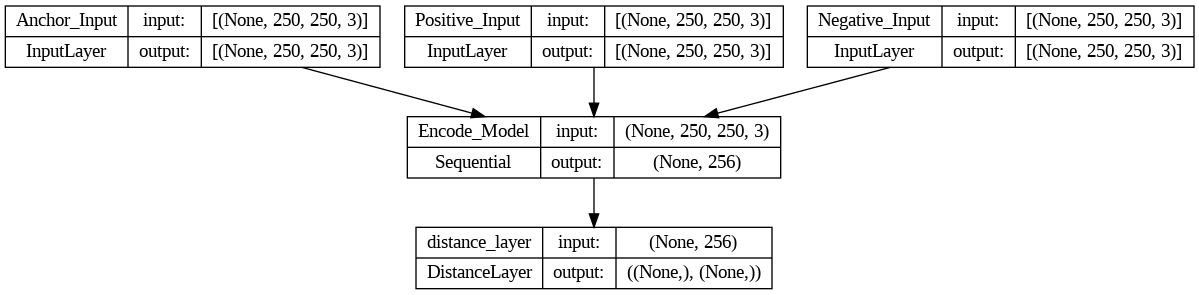

In [19]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together

We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

We'll create a **Mean metric** instance to track the loss of the training process.

**Triplet Loss Function:**

<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [20]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [21]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## **Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function

**test_on_triplets()** function will be responsible for testing the model on test_triplets. It'll collect metrics **(accuracy, means, stds)** by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [22]:
def test_on_triplets(batch_size = 16):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size,ROOT=ROOT_test):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [25]:
save_all = False
epochs = 1
batch_size = 64

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size,ROOT=ROOT_train):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 338 sec)
Loss on train    = 0.01331
1/1 [==============================] - 5s 5s/step
Accuracy on test = 0.95926


In [ ]:
siamese_model.save_weights("siamese_model-final")

## **Evaluating the Model**


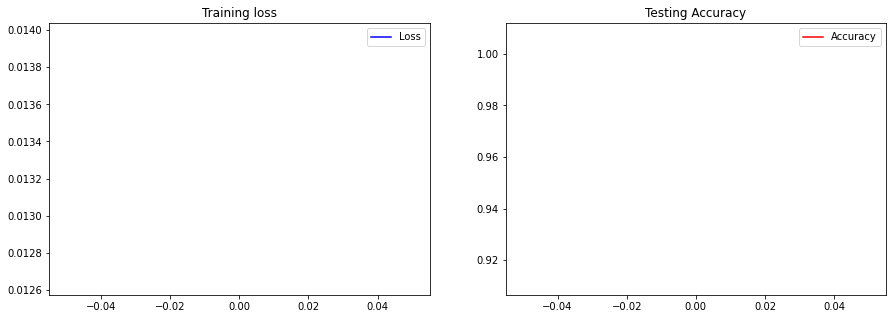

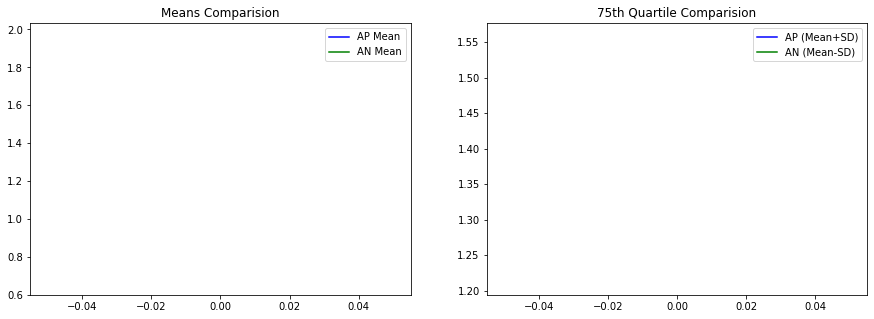

In [26]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

## **Using the Model**

Now that we've finished training our model, we need to **extract the encoder** so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [27]:
def extract_encoder(model):
    encoder = get_encoder((250, 250, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                      

### Classify Images

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [28]:
def classify_images(face_list1, face_list2, threshold=1.3):
    print(type(face_list1))
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

<class 'numpy.ndarray'>
8/8 [==============================] - 1s 143ms/step
<class 'numpy.ndarray'>
8/8 [==============================] - 1s 146ms/step

Accuracy of model: 0.994140625



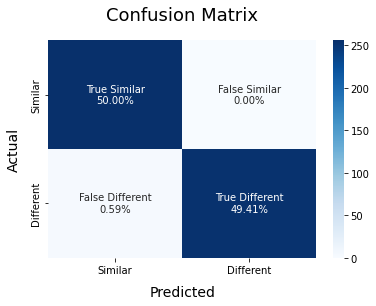

In [29]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256,ROOT=ROOT_train):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

## References

- FaceNet: A Unified Embedding for Face Recognition and Clustering: https://arxiv.org/abs/1503.03832
- Image similarity estimation using a Siamese Network with a triplet loss: https://keras.io/examples/vision/siamese_network/
- Celebrity Face Recognition: https://www.kaggle.com/ravehgillmore/celebrity-face-recognition/
- Face Recognition using Siamese Networks: https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4


In [31]:
encoder

In [32]:
def classify_images_our_version(face_list1, face_list2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)[0]
    return distance

In [33]:
def read_image_label(ROOT):
    path = ROOT
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = path.split("/")[-2]
    image = tf.constant(np.expand_dims(image, axis=0))
    return image,label

In [34]:
image_1 = read_image_label("/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new/class_1/1.jpg")
image_2 =  read_image_label("/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new/class_1/2.jpg")
image_3 =  read_image_label("/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new/class_4/2.jpg")

In [35]:
classify_images_our_version(image_1[0],image_2[0])

1/1 [==============================] - 0s 31ms/step


0.40339774

In [36]:
read_image_label("/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new/class_1/1.jpg")

(<tf.Tensor: shape=(1, 250, 250, 3), dtype=uint8, numpy=
 array([[[[  1,   0,   2],
          [  1,   0,   2],
          [  1,   0,   2],
          ...,
          [  1,   0,   0],
          [  1,   0,   2],
          [  1,   0,   2]],
 
         [[  1,   0,   2],
          [  0,   0,   2],
          [  1,   0,   2],
          ...,
          [  0,   0,   0],
          [  1,   0,   2],
          [  0,   0,   2]],
 
         [[  0,   0,   0],
          [  0,   1,   0],
          [  0,   0,   0],
          ...,
          [  0,   1,   0],
          [  0,   0,   0],
          [  0,   1,   0]],
 
         ...,
 
         [[144,  88,  37],
          [144,  88,  37],
          [143,  87,  36],
          ...,
          [181, 163, 163],
          [177, 157, 158],
          [178, 158, 159]],
 
         [[142,  89,  35],
          [142,  89,  35],
          [141,  86,  32],
          ...,
          [178, 160, 160],
          [174, 154, 155],
          [177, 157, 156]],
 
         [[140,  87,  33],


In [38]:
import os

def get_image_paths(directory):
    """
    Takes a directory path as an argument and returns a list of all image file paths within the directory and its subdirectories.
    """
    # Define a list to store the image file paths
    image_paths = []

    # Iterate over all the directories and files within the given directory
    for root, dirs, files in os.walk(directory):
        # Iterate over all the files within the current directory
        for file in files:
            # Check if the file is an image file
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                # Construct the full path to the image file and append it to the list
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

    # Return the list of image file paths
    return image_paths

train_new_dir = "/content/drive/MyDrive/capstone_project/selected/RGBFace/train_new"

test_new_dir = "/content/drive/MyDrive/capstone_project/selected/RGBFace/test_new"

# image_paths_of_train = get_image_paths(train_new_dir)
# image_paths_of_train = get_image_paths(test_new_dir)


In [ ]:
image_paths_of_train = get_image_paths(train_new_dir)
image_paths_of_test = get_image_paths(test_new_dir)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label_test = []
count_label_train = []
count = 0

for image_test_path in image_paths_of_test:
  image_test,label_test=read_image_label(image_test_path)
  count_label_test.append(label_test)
  for image_train_path in image_paths_of_train:
    print(count)
    image_train, label_train = read_image_label(image_train_path)
    count_label_train.append(label_train)
    euclidean_distance = classify_images_our_version(image_test,image_train)
    predict.append(euclidean_distance)
    if label_test==label_train: # if labels of two images are same append them to same_dissimilar
      same_disssimilarity.append(euclidean_distance)
    else:
      different_disssimilarity.append(euclidean_distance)
    count += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step
2608
1/1 [==============================] - 0s 24ms/step
2609
1/1 [==============================] - 0s 40ms/step
2610
1/1 [==============================] - 0s 32ms/step
2611
1/1 [==============================] - 0s 25ms/step
2612
1/1 [==============================] - 0s 26ms/step
2613
1/1 [==============================] - 0s 28ms/step
2614
1/1 [==============================] - 0s 29ms/step
2615
1/1 [==============================] - 0s 25ms/step
2616
1/1 [==============================] - 0s 43ms/step
2617
1/1 [==============================] - 0s 38ms/step
2618
1/1 [==============================] - 0s 27ms/step
2619
1/1 [==============================] - 0s 28ms/step
2620
1/1 [==============================] - 0s 26ms/step
2621
1/1 [==============================] - 0s 23ms/step
2622
1/1 [==============================] - 0s 26ms/step
2623
1/1 [==============================] 

In [ ]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

In [ ]:
(64944*3)/60